In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
# import plotly.express as px
from collections import Counter
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
#import shao
import pickle
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.inspection import PartialDependenceDisplay
import sys

In [2]:
!pip install shap

In [3]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [4]:
plt.rcParams["mathtext.fontset"]
plt.rcParams.update({'font.size': 28, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

In [5]:
transaction_frequency_opcode = ['address', 'balance', 'lifetime', 'tx_in', 'tx_out', 'investment_in',
 'payment_out', 'investment_to_contract/tx_in', 'payment_from_contract/tx_out',
 '#addresses_paying_contract', '#addresses_paid_by_contract', 'mean_v1', 'sdev_v1', 'mean_v2', 'sdev_v2', 'paid_rate',
 'paid_one', 'percentage_some_tx_in', 'sdev_tx_in', 'percentage_some_tx_out', 'sdev_tx_out', 'owner_gets_eth_Wo_investing',
 'owner_gets_eth_investing', 'owner_no_eth', 'PUSH', 'INVALID', 'DUP', 'JUMPDEST', 'STOP', 'MSTORE', 'JUMPI', 'REVERT', 'CALLVALUE',
 'ISZERO', 'CODECOPY', 'RETURN', 'LOG', 'SHA3', 'MSTORE8', 'SWAP', 'POP', 'ADD', 'MLOAD', 'AND', 'SUB', 'CALLDATALOAD', 'EXP',
 'MUL', 'SLOAD', 'EQ', 'JUMP', 'DIV', 'CALLER', 'CALLDATACOPY', 'SSTORE', 'NOT', 'CALL', 'LT', 'GT', 'OR', 'ADDRESS2', 'TIMESTAMP',
 'GASLIMIT', 'GAS', 'ORIGIN', 'BALANCE3', 'CALLDATASIZE', 'SAR', 'MSIZE', 'CODESIZE', 'COINBASE', 'CREATE2', 'EXTCODESIZE', 'CALLCODE', 'SHL',
 'BLOCKHASH', 'RETURNDATASIZE', 'SHR', 'GETPC', 'DELEGATECALL', 'MOD', 'ADDMOD', 'NUMBER', 'XOR', 'SLT', 'EXTCODECOPY', 'MULMOD', 'CREATE', 'SELFDESTRUCT',
 'STATICCALL', 'RETURNDATACOPY', 'SGT', 'DIFFICULTY', 'SMOD', 'BYTE', 'SIGNEXTEND', 'CHAINID', 'SELFBALANCE', 'GASPRICE', 'EXTCODEHASH', 'SDIV', 'target']

In [6]:
best_features_set = ['balance',
 'lifetime',
 'tx_in',
 'investment_to_contract/tx_in',
 'sdev_v2',
 'paid_rate',
 'PUSH',
 'INVALID',
 'DUP',
 'JUMPDEST',
 'STOP',
 'JUMPI',
 'REVERT',
 'CALLVALUE',
 'ISZERO',
 'CODECOPY',
 'RETURN',
 'LOG',
 'SHA3',
 'SWAP',
 'POP',
 'ADD',
 'MLOAD',
 'AND',
 'SUB',
 'CALLDATALOAD',
 'EXP',
 'MUL',
 'SLOAD',
 'JUMP',
 'DIV',
 'CALLER',
 'SSTORE',
 'NOT',
 'CALL',
 'LT',
 'GT',
 'OR',
 'TIMESTAMP',
 'GAS',
 'BALANCE3',
 'CALLDATASIZE',
 'RETURNDATASIZE']



In [7]:
#dataset_path = ("\\Users\\lucap\\OneDrive\\Desktop\\Smart Ponzi\\bytecode_opcode_8k.csv")
dataset_path = ("/content/bytecode_opcode_8k.csv")
db = pd.read_csv(dataset_path, header = 0, delimiter = ';')
db = db.fillna(0)

In [8]:
df_transaction_weighted_opcode = db[transaction_frequency_opcode].copy()
y = df_transaction_weighted_opcode.loc[:, ['target']].values
y = pd.DataFrame(y,columns=['target'])

dataset_account = db.iloc[:, 0:24]
dataset_opcode = db.iloc[:, 24:101]

dataset_opcode['all_opcode'] = dataset_opcode[list(dataset_opcode.columns)].sum(axis=1) #generate all_opcode
dataset_opcode = dataset_opcode[:].div(dataset_opcode['all_opcode'], axis=0)
dataset_opcode = dataset_opcode.drop(['all_opcode'], axis = 1)

df_transaction_weighted_opcode = pd.concat([dataset_account, dataset_opcode, y], axis=1)
df_transaction_weighted_opcode = df_transaction_weighted_opcode.fillna(0)

In [9]:
col_name = transaction_frequency_opcode[1:-1]

In [10]:
addr= df_transaction_weighted_opcode.iloc[:, 0]
X = df_transaction_weighted_opcode.iloc[:, 1:-1].values # rimuovo la prima colonna che contiene gli indirizzi
y = df_transaction_weighted_opcode.loc[:, ['target']].values

addr = pd.DataFrame(addr)
X = pd.DataFrame(X)
X.columns = col_name

In [11]:
X['address'] = addr['address']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state = 42, stratify=y)

In [13]:
df_X_train_adr = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[0:1])
df_X_test_adr = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[0:1])

In [14]:
X_train = X_train.iloc[:, :-1].copy()
X_test = X_test.iloc[:, :-1].copy()

In [15]:
best_params =[

        {
            'classifier': [lgb.LGBMClassifier(boosting_type='gbdt', n_jobs=4, importance_type='split',random_state=42)],
            'classifier__learning_rate' : [0.1],
            'classifier__n_estimators' : [140],
            'classifier__max_depth' : [15],
            'classifier__colsample_bytree' : [0.5],
            'classifier__reg_alpha' : [0.1],
            'classifier__reg_lambda' : [1],
        }
]

In [16]:
data = {}
pipeline = Pipeline(steps=[('classifier',RandomForestClassifier(random_state=42))])

grid_search = GridSearchCV(pipeline, best_params, cv=10,
                               scoring='roc_auc',
                               return_train_score=True,n_jobs=4,verbose=2)
grid_search.fit(X_train, y_train.ravel())

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=4,
             param_grid=[{'classifier': [LGBMClassifier(colsample_bytree=0.5,
                                                        max_depth=15,
                                                        n_estimators=140,
                                                        n_jobs=4,
                                                        random_state=42,
                                                        reg_alpha=0.1,
                                                        reg_lambda=1)],
                          'classifier__colsample_bytree': [0.5],
                          'classifier__learning_rate': [0.1],
                          'classifier__max_depth': [15],
                          'classifier__n_estimators': [140],
                          'classifier__reg_alpha': [0.1],
                          'classifier__reg_lambda': [1]}],
             return_train_score=True, scoring='roc_auc', verbose=2)

In [17]:
print(grid_search.best_params_)
print('Test accuracy: %.3f' % grid_search.score(X_test, y_test))

{'classifier': LGBMClassifier(colsample_bytree=0.5, max_depth=15, n_estimators=140, n_jobs=4,
               random_state=42, reg_alpha=0.1, reg_lambda=1), 'classifier__colsample_bytree': 0.5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 15, 'classifier__n_estimators': 140, 'classifier__reg_alpha': 0.1, 'classifier__reg_lambda': 1}
Test accuracy: 0.965


In [18]:
data = {}
y_pred_train = grid_search.best_estimator_.predict(X_train)
data['best_precision_training'] = [precision_score(y_train, y_pred_train)] # TP / (FP + TP)
data['best_recall_training'] = [recall_score(y_train, y_pred_train)]	     # TP / (FN + TP)
data['best_accuracy_training'] = [accuracy_score(y_train, y_pred_train)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_training'] = [f1_score(y_train, y_pred_train)]
# Confusion matrix
y_pred = grid_search.best_estimator_.predict(X_test)
data['best_precision_test'] = [precision_score(y_test, y_pred)] # TP / (FP + TP)
data['best_recall_test'] = [recall_score(y_test, y_pred)]	     # TP / (FN + TP)
data['best_accuracy_test'] = [accuracy_score(y_test, y_pred)]	 # (TP + TN)/ (TP + FN + TN + FP)
data['best_f1_test'] = [f1_score(y_test, y_pred)]

In [19]:
data

{'best_precision_training': [1.0],
 'best_recall_training': [0.9911838790931989],
 'best_accuracy_training': [0.9989655681986109],
 'best_f1_training': [0.995572422517394],
 'best_precision_test': [0.9067796610169492],
 'best_recall_test': [0.7642857142857142],
 'best_accuracy_test': [0.9631799163179916],
 'best_f1_test': [0.8294573643410853]}

In [20]:
model = grid_search.best_estimator_

In [21]:
df_X_train_full = pd.DataFrame(X_train,columns=df_transaction_weighted_opcode.columns[1:-1])
df_X_test_full = pd.DataFrame(X_test,columns=df_transaction_weighted_opcode.columns[1:-1])

df_X_train_full = df_X_train_full[best_features_set].copy()
df_X_test_full = df_X_test_full[best_features_set].copy()

model.fit(df_X_train_full,y_train.ravel())
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test,y_pred_proba_best)
auc_score = roc_auc_score(y_test,y_pred_proba_best)


y_pred_best = model.predict(df_X_test_full)
best_precision_test= precision_score(y_test, y_pred_best) # TP / (FP + TP)
best_recall_test = recall_score(y_test, y_pred_best)	     # TP / (FN + TP)
best_accuracy_test = accuracy_score(y_test, y_pred_best)	 # (TP + TN)/ (TP + FN + TN + FP)
best_f1_test = f1_score(y_test, y_pred_best)

print('AUC: {:.3f}'.format(auc_score))
print('Precision: {:.3f}'.format(best_precision_test))
print('Recall: {:.3f}'.format(best_recall_test))
print('Accuracy: {:.3f}'.format(best_accuracy_test))
print('F1: {:.3f}'.format(best_f1_test))

AUC: 0.964
Precision: 0.926
Recall: 0.800
Accuracy: 0.969
F1: 0.858


In [22]:
np.set_printoptions(threshold=sys.maxsize)

In [23]:
def plot_confusion_matrix(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10,10))
    ax = sns.heatmap(cm, annot=True, cmap='Greens', cbar=False, fmt='d',annot_kws={"fontsize":38})
#     cbar = ax.collections[0].colorbar
#     cbar.ax.tick_params(labelsize=18)
    plt.xticks(fontsize=38)
    plt.yticks(fontsize=38)
    plt.savefig('cm_{}.png'.format(name))
    plt.show()

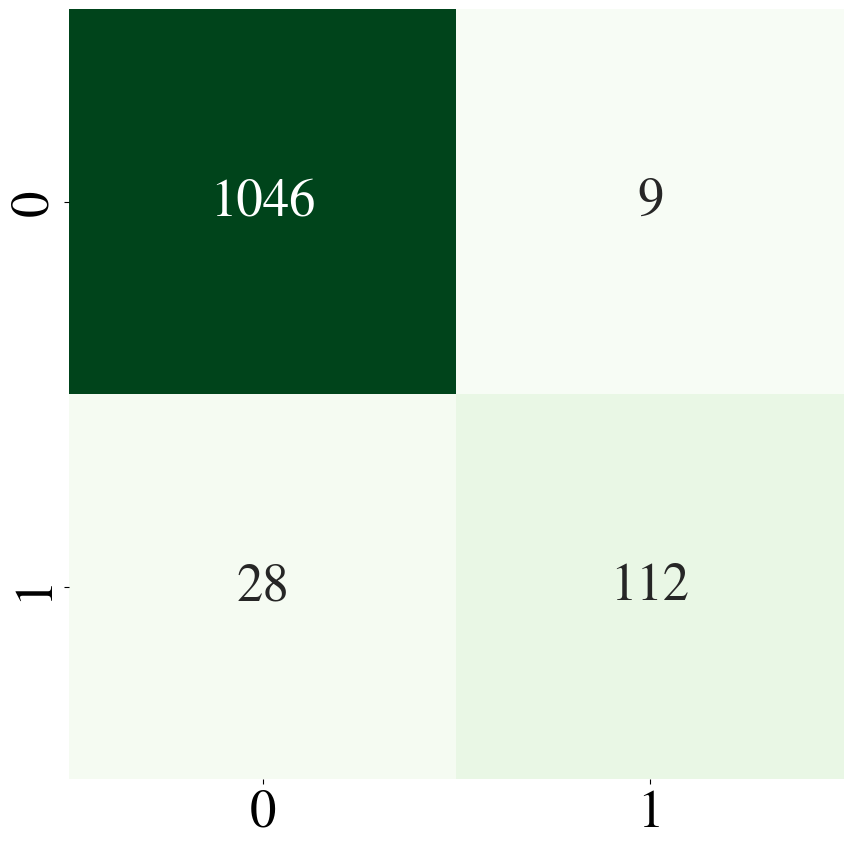

In [24]:
plot_confusion_matrix(y_test,y_pred_best,"Best features set")

In [25]:
cls = grid_search.best_estimator_

In [26]:
explainer_tree = shap.TreeExplainer(cls.named_steps['classifier'])
shap_values_tree = explainer_tree.shap_values(df_X_test_full)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [27]:
def get_shaps(classifier, dataset):
    print(dataset.shape)
    explainer = shap.Explainer(classifier, dataset)
    shap_values = explainer(dataset,check_additivity=False)

    explainer_tree = shap.TreeExplainer(classifier)
    shap_values_tree = explainer_tree.shap_values(dataset)
    return shap_values,shap_values_tree

In [28]:
def plot_beeswarn(df,shap_values,filename,class_index=1):
    shap.summary_plot(shap_values[class_index], df,show=False,max_display=10,color='red',color_bar=True,class_names=True)
    fig = plt.gcf() # gcf means "get current figure"
    ax = plt.gca() #gca means "get current axes"

    fig.axes[1].yaxis.get_label().set_fontsize(24)
    # fig.axes[1].set_fontsize(24)
    plt.xlabel('SHAP value',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.tight_layout()
    plt.savefig('{}.png'.format(filename))

In [29]:
explainer = shap.Explainer(cls.named_steps['classifier'], df_X_test_full)
shap_values = explainer(df_X_test_full,check_additivity=False)

 94%|=================== | 1126/1195 [00:22<00:01]       

In [30]:
shap_values, shap_values_tree = get_shaps(cls.named_steps['classifier'], df_X_test_full)

(1195, 43)


 93%|=================== | 1110/1195 [00:17<00:01]       LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


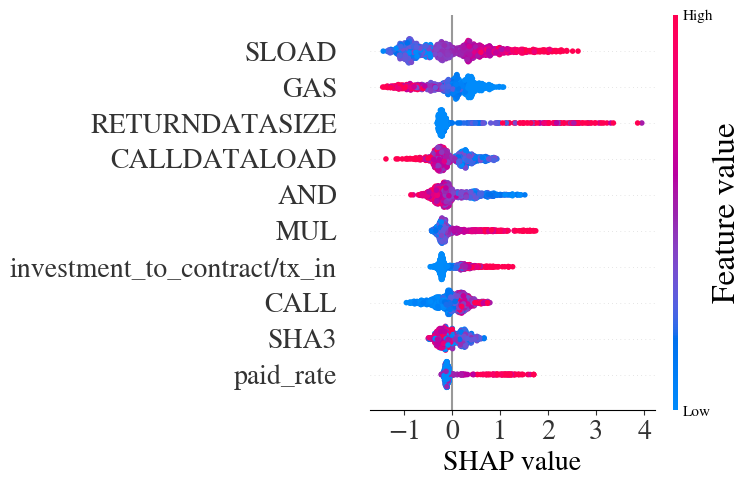

In [31]:
plot_beeswarn(df_X_test_full,shap_values_tree,'total',1)

In [32]:
from sklearn.inspection import PartialDependenceDisplay

In [33]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

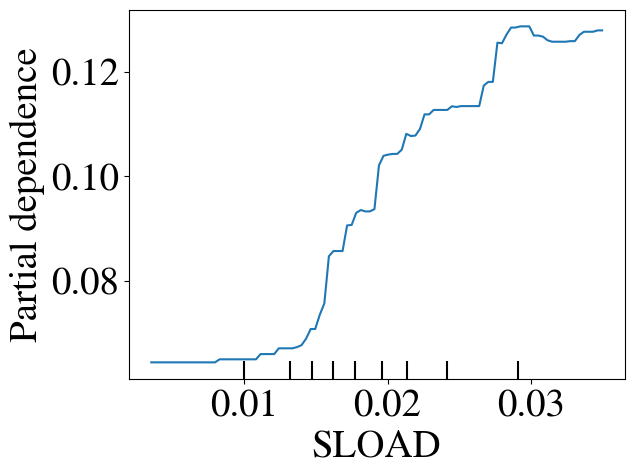

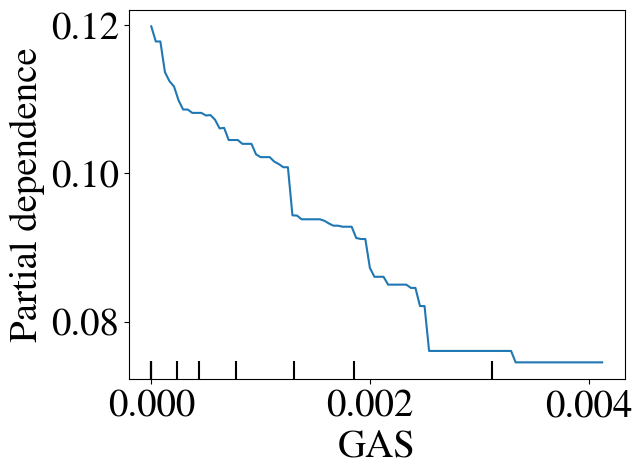

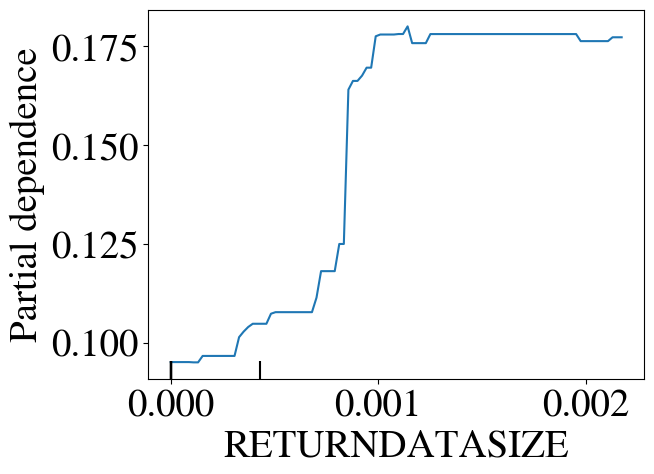

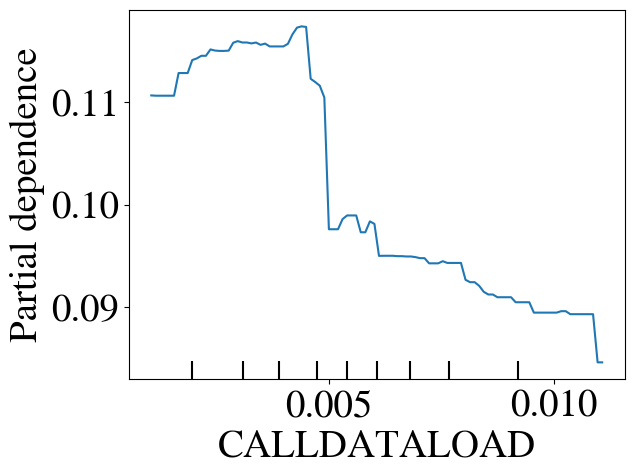

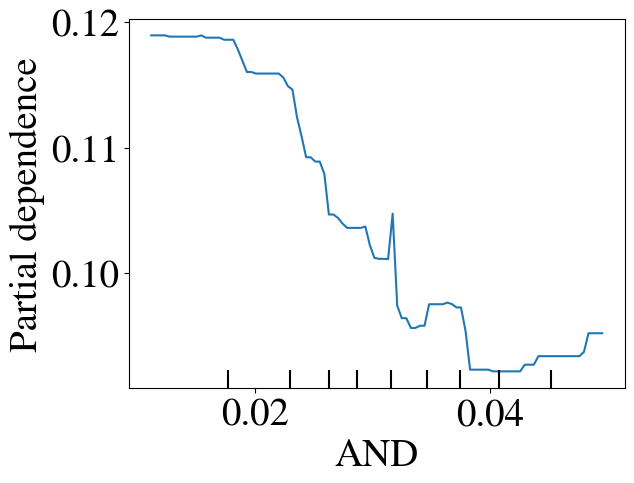

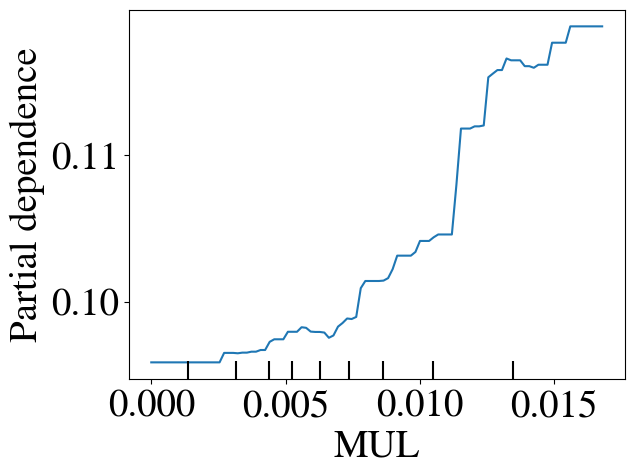

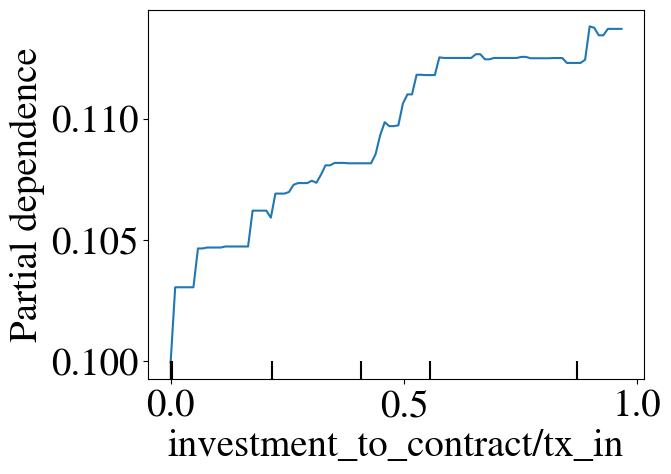

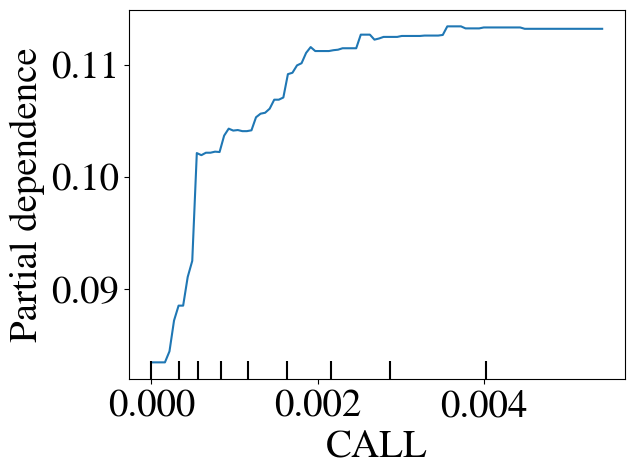

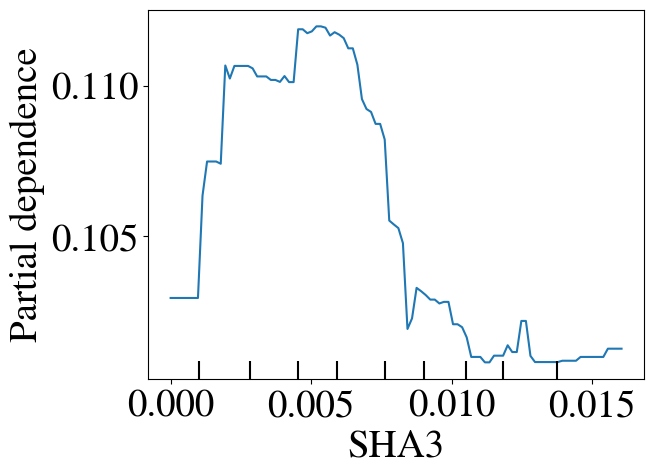

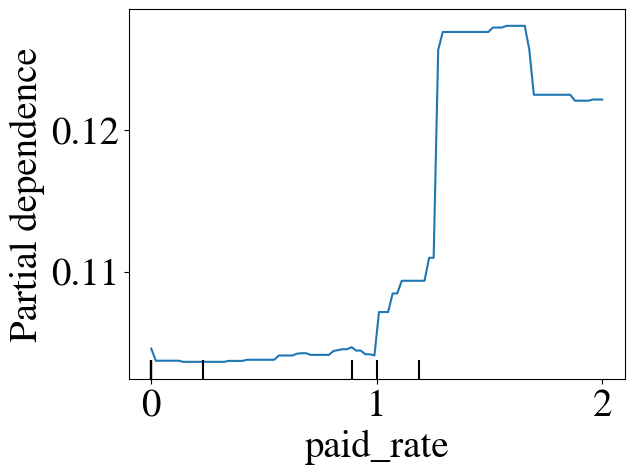

In [34]:
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x])

In [35]:
y_pred_proba_best = model.predict_proba(df_X_test_full)[:, 1]

In [36]:
model.predict_proba

<bound method Pipeline.predict_proba of Pipeline(steps=[('classifier',
                 LGBMClassifier(colsample_bytree=0.5, max_depth=15,
                                n_estimators=140, n_jobs=4, random_state=42,
                                reg_alpha=0.1, reg_lambda=1))])>

In [37]:
y_pred_proba_best

array([3.80848292e-02, 9.98629154e-01, 4.36141602e-04, 5.81267739e-03,
       4.74696411e-03, 1.35948081e-03, 4.80550916e-03, 2.00011071e-02,
       9.90331203e-01, 5.36534291e-03, 4.95298271e-05, 8.05977135e-04,
       2.69372625e-04, 3.91781006e-03, 1.57775941e-03, 8.23058777e-04,
       1.67696329e-03, 1.17288712e-03, 2.41372591e-04, 2.21824938e-04,
       1.24348093e-03, 1.05487663e-02, 4.08109044e-03, 9.44029952e-02,
       4.53310080e-04, 9.97379297e-01, 1.22195320e-02, 2.09300137e-03,
       8.70529743e-05, 2.63200523e-02, 1.94920795e-02, 6.90306717e-04,
       2.44372708e-04, 5.91325793e-04, 2.05217852e-03, 2.31463880e-03,
       3.45801290e-04, 4.80333162e-04, 9.95271997e-01, 5.09920388e-03,
       9.93105121e-01, 2.84889268e-02, 3.34506292e-03, 1.46858000e-03,
       2.71836198e-04, 7.87544429e-05, 2.61034831e-03, 2.10663009e-03,
       1.06533261e-03, 2.53550636e-04, 7.11848415e-03, 1.57286334e-03,
       5.91629833e-03, 2.64311556e-03, 8.87752515e-01, 2.47808987e-04,
      

False Negative and False Positive

In [38]:
df_check = df_X_test_full.copy()
df_check['prediction'] = y_pred
df_check['label'] = y_test
df_check['probability'] = y_pred_proba_best
df_check['correct'] = df_check.apply(lambda x: 1 if x.prediction == x.label else 0,axis=1)
df_check['address'] = df_X_test_adr

In [39]:
df_check

,balance,lifetime,tx_in,investment_to_contract/tx_in,sdev_v2,paid_rate,PUSH,INVALID,DUP,JUMPDEST,...,TIMESTAMP,GAS,BALANCE3,CALLDATASIZE,RETURNDATASIZE,prediction,label,probability,correct,address
5386,0.000000,0.0,1.0,0.0000,0.000000,0.0000,0.280497,0.005439,0.116550,0.036519,...,0.000000,0.000000,0.001554,0.000777,0.000000,0.0,0.0,0.038085,1,0x804a86d6cb1c301fbc38b5d3233471a63d3cbf3d
7297,0.106035,499.0,156.0,0.3910,0.141623,1.0820,0.265169,0.011236,0.143820,0.069213,...,0.000000,0.000000,0.000000,0.000449,0.000000,1.0,1.0,0.998629,1,0xda9018d28bc96f4509645fbc28e872c7d678931d
6502,0.100000,1785.0,8.0,0.6250,2.066117,1.0000,0.238737,0.018526,0.117053,0.066947,...,0.001684,0.003368,0.000421,0.000421,0.000000,0.0,0.0,0.000436,1,0xb334247f37f4d9dcbf480c4f28fcc7376410a906
7771,0.000000,603.0,749.0,0.5073,30.533024,1.0000,0.211890,0.003818,0.185438,0.046359,...,0.000000,0.000545,0.000000,0.003545,0.002182,0.0,0.0,0.005813,1,0xf3c9dbb9598c21fe64a67d0586adb5d6eb66bc63
2636,0.000000,86.0,30.0,0.0333,0.010000,1.0000,0.247638,0.011811,0.152756,0.053543,...,0.000000,0.000394,0.000000,0.000394,0.000000,0.0,0.0,0.004747,1,0xed37a1395e3c9db3e6543ea770b91ea0e8bd4f05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5581,0.000000,1.0,52.0,0.9808,2.374534,1.5294,0.267898,0.000469,0.170174,0.028323,...,0.001721,0.000000,0.000000,0.002034,0.000000,1.0,1.0,0.997899,1,0x893e861a0615f66475c8151bd4a9c348111b0c5e
5772,0.000000,2.0,18.0,0.8889,0.122391,0.5625,0.254409,0.012787,0.135362,0.063492,...,0.001323,0.000441,0.002205,0.000441,0.000000,0.0,0.0,0.007589,1,0x918becb3a725caaa5f8e277bb0b914d271331e99
2325,0.000000,9.0,9880.0,0.0000,0.000000,0.0000,0.244816,0.012368,0.143689,0.068025,...,0.000728,0.000728,0.000000,0.001091,0.000000,0.0,0.0,0.000091,1,0xd26114cd6ee289accf82350c8d8487fedb8a0c07
2033,0.000000,11.0,19.0,0.0000,0.000000,0.0000,0.205209,0.013471,0.176920,0.062416,...,0.000449,0.000449,0.000000,0.000449,0.000000,0.0,0.0,0.000782,1,0xb6ba63978b5c43ad9cac0622aa34c5c1073fadc3


In [40]:
db_prova_1 = db

In [53]:
condizione = db_prova_1['address'] == '0xa9e2320d9e6c17eb45a921cb2698b42256f5e142'

In [54]:
print(db_prova_1[condizione])

                                         address  balance  lifetime  tx_in  \
1870  0xa9e2320d9e6c17eb45a921cb2698b42256f5e142   0.6146      2163    813   

      tx_out  investment_in  payment_out  investment_to_contract/tx_in  \
1870     257            212          257                        0.2608   

      payment_from_contract/tx_out  #addresses_paying_contract  ...  \
1870                           1.0                           3  ...   

      DIFFICULTY  SMOD  BYTE  SIGNEXTEND  CHAINID  SELFBALANCE  GASPRICE  \
1870         0.0   0.0   0.0         0.0      0.0          0.0       0.0   

      EXTCODEHASH  SDIV  target  
1870          0.0   0.0     0.0  

[1 rows x 102 columns]


In [ ]:
pd.set_option('display.max_rows', None)

prediction	label	probability

In [46]:
df_check.sort_values(by=['probability'])

,balance,lifetime,tx_in,investment_to_contract/tx_in,sdev_v2,paid_rate,PUSH,INVALID,DUP,JUMPDEST,...,TIMESTAMP,GAS,BALANCE3,CALLDATASIZE,RETURNDATASIZE,prediction,label,probability,correct,address
1963,0.000000,274.0,9961.0,0.0000,0.000000,0.0000,0.254780,0.010227,0.151178,0.052468,...,0.000000,0.000445,0.000445,0.000445,0.00000,0.0,0.0,0.000037,1,0xb0866289e870d2efc282406cf4123df6e5bcb652
503,0.000000,45.0,11.0,0.0000,0.000000,0.0000,0.205891,0.014576,0.160947,0.049803,...,0.000000,0.000607,0.000000,0.000304,0.00000,0.0,0.0,0.000038,1,0x2DE90964c53308f8Bdf68f43cd3feac1e1e95587
2487,0.000000,1479.0,7745.0,0.0000,0.000000,0.0000,0.247376,0.012323,0.154724,0.050662,...,0.000000,0.000456,0.000000,0.000456,0.00000,0.0,0.0,0.000039,1,0xe0c72452740414d861606a44ccd5ea7f96488278
6660,0.000000,143.0,7208.0,0.0000,0.000000,0.0000,0.219830,0.002266,0.158829,0.045515,...,0.000000,0.001511,0.000000,0.000189,0.00000,0.0,0.0,0.000048,1,0xb9e7f8568e08d5659f5d29c4997173d84cdf2607
606,0.000000,299.0,33.0,0.0000,0.000000,0.0000,0.230869,0.006485,0.175962,0.058798,...,0.000000,0.000000,0.000432,0.000432,0.00000,0.0,0.0,0.000050,1,0x36aff6fe8ffe81844bba32427f622af6c47eab66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3549,0.000000,1.0,301.0,0.9934,2.281470,2.5485,0.214994,0.014333,0.181918,0.038589,...,0.000551,0.001103,0.000551,0.002205,0.00441,1.0,1.0,0.998638,1,0x243ce58ad1d2996399b0c110f013901d2f50243f
7938,0.012784,499.0,144.0,0.4167,0.065909,0.9667,0.265169,0.011236,0.143820,0.069213,...,0.000000,0.000000,0.000000,0.000449,0.00000,1.0,1.0,0.998953,1,0xfc8decea972435b89be675996b6bf825aad06f9d
4172,1.800000,3.0,20.0,0.9000,10.279669,1.4444,0.242261,0.006729,0.166891,0.033647,...,0.000000,0.000000,0.000000,0.001346,0.00000,1.0,1.0,0.998977,1,0x4229a873bbd207deef8f41e807e563c26033d118
5180,0.008500,0.0,14.0,0.9286,5.500690,1.1538,0.242261,0.006729,0.166891,0.033647,...,0.000000,0.000000,0.000000,0.001346,0.00000,1.0,1.0,0.998988,1,0x750241c16c9fb878a7afd2b07b80f53e02c3f634


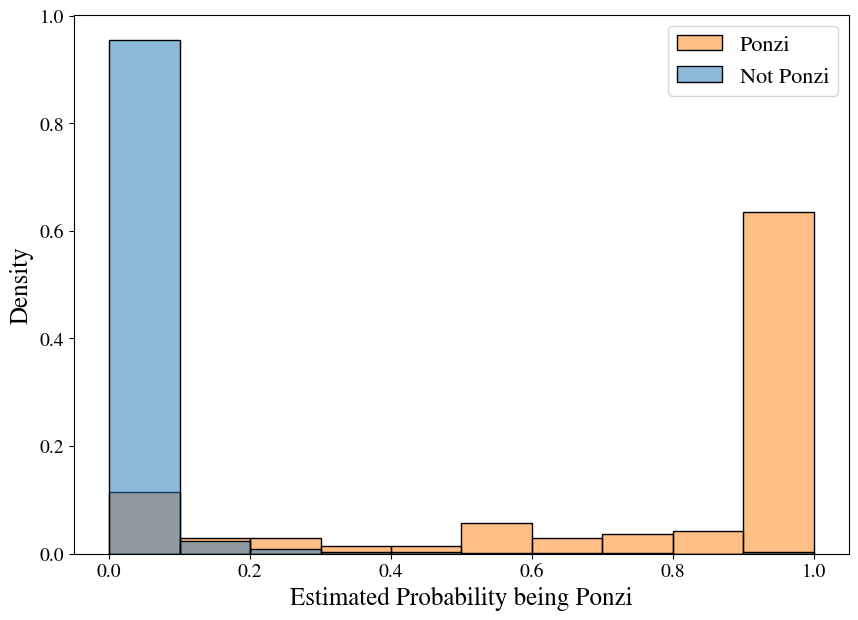

In [47]:
fig=plt.figure(figsize=(10,7))
sns.histplot(data=df_check,x='probability',hue='label',bins=np.arange(0,1.1,0.1),stat='probability',common_norm=False)
plt.xlabel('Estimated Probability being Ponzi',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(loc='best',labels=['Ponzi','Not Ponzi'],fontsize=16)
plt.savefig('distribution_probability.png')

In [48]:
df_check['FP'] = df_check.apply(lambda x: 1 if x['prediction'] == 1 and x['correct'] ==0 else 0, axis=1 )
df_check['FN'] = df_check.apply(lambda x: 1 if x['prediction'] == 0 and x['correct'] ==0 else 0, axis=1 )

In [49]:
df_check

,balance,lifetime,tx_in,investment_to_contract/tx_in,sdev_v2,paid_rate,PUSH,INVALID,DUP,JUMPDEST,...,BALANCE3,CALLDATASIZE,RETURNDATASIZE,prediction,label,probability,correct,address,FP,FN
5386,0.000000,0.0,1.0,0.0000,0.000000,0.0000,0.280497,0.005439,0.116550,0.036519,...,0.001554,0.000777,0.000000,0.0,0.0,0.038085,1,0x804a86d6cb1c301fbc38b5d3233471a63d3cbf3d,0,0
7297,0.106035,499.0,156.0,0.3910,0.141623,1.0820,0.265169,0.011236,0.143820,0.069213,...,0.000000,0.000449,0.000000,1.0,1.0,0.998629,1,0xda9018d28bc96f4509645fbc28e872c7d678931d,0,0
6502,0.100000,1785.0,8.0,0.6250,2.066117,1.0000,0.238737,0.018526,0.117053,0.066947,...,0.000421,0.000421,0.000000,0.0,0.0,0.000436,1,0xb334247f37f4d9dcbf480c4f28fcc7376410a906,0,0
7771,0.000000,603.0,749.0,0.5073,30.533024,1.0000,0.211890,0.003818,0.185438,0.046359,...,0.000000,0.003545,0.002182,0.0,0.0,0.005813,1,0xf3c9dbb9598c21fe64a67d0586adb5d6eb66bc63,0,0
2636,0.000000,86.0,30.0,0.0333,0.010000,1.0000,0.247638,0.011811,0.152756,0.053543,...,0.000000,0.000394,0.000000,0.0,0.0,0.004747,1,0xed37a1395e3c9db3e6543ea770b91ea0e8bd4f05,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5581,0.000000,1.0,52.0,0.9808,2.374534,1.5294,0.267898,0.000469,0.170174,0.028323,...,0.000000,0.002034,0.000000,1.0,1.0,0.997899,1,0x893e861a0615f66475c8151bd4a9c348111b0c5e,0,0
5772,0.000000,2.0,18.0,0.8889,0.122391,0.5625,0.254409,0.012787,0.135362,0.063492,...,0.002205,0.000441,0.000000,0.0,0.0,0.007589,1,0x918becb3a725caaa5f8e277bb0b914d271331e99,0,0
2325,0.000000,9.0,9880.0,0.0000,0.000000,0.0000,0.244816,0.012368,0.143689,0.068025,...,0.000000,0.001091,0.000000,0.0,0.0,0.000091,1,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,0,0
2033,0.000000,11.0,19.0,0.0000,0.000000,0.0000,0.205209,0.013471,0.176920,0.062416,...,0.000000,0.000449,0.000000,0.0,0.0,0.000782,1,0xb6ba63978b5c43ad9cac0622aa34c5c1073fadc3,0,0


In [50]:
df_fp = df_check[df_check['FP']==1].copy()
df_fn = df_check[df_check['FN']==1].copy()

In [51]:
df_fp

,balance,lifetime,tx_in,investment_to_contract/tx_in,sdev_v2,paid_rate,PUSH,INVALID,DUP,JUMPDEST,...,BALANCE3,CALLDATASIZE,RETURNDATASIZE,prediction,label,probability,correct,address,FP,FN
2237,0.00000,0.0,4.0,0.2500,0.100000,1.0000,0.238411,0.000000,0.145695,0.069536,...,0.003311,0.003311,0.000000,1.0,0.0,0.636524,0,0xca16790e9bb125392960e78befff1d4df4cb5b58,1,0
5050,0.00100,0.0,2.0,0.5000,0.000000,0.0000,0.239037,0.014177,0.168810,0.067260,...,0.000000,0.000330,0.000000,1.0,0.0,0.997304,0,0x6e692023289738afd6ec4a89bf048c5fbe2db884,1,0
1870,0.61460,2163.0,813.0,0.2608,63.312962,1.2123,0.224524,0.000000,0.172452,0.030795,...,0.000560,0.000560,0.000000,1.0,0.0,0.429594,0,0xa9e2320d9e6c17eb45a921cb2698b42256f5e142,1,0
5794,0.00000,0.0,4.0,0.5000,0.002298,1.0000,0.252166,0.013432,0.131282,0.060659,...,0.001733,0.000433,0.000000,1.0,0.0,0.966851,0,0x927a4e90c3728f04cc373cd4c445daafa9e54df7,1,0
2582,0.00000,0.0,2.0,0.0000,0.000000,0.0000,0.280449,0.002671,0.126603,0.036859,...,0.002137,0.000534,0.000000,1.0,0.0,0.979078,0,0xE89938a1cBF4205096405718E1699Fa84608c4bd,1,0
5611,0.00500,66.0,24.0,0.9583,0.000000,1.1739,0.213986,0.006768,0.192394,0.046084,...,0.000645,0.000322,0.003223,1.0,0.0,0.754273,0,0x8a9771775ed9a5e3440f89ad790764c188e16191,1,0
3054,0.00000,0.0,4.0,0.5000,0.000000,0.5000,0.255618,0.009363,0.156367,0.062266,...,0.000468,0.000468,0.000000,1.0,0.0,0.963398,0,0x0cf1cbb130e48d9273e16491f77908024560e8e7,1,0
232,0.00000,398.0,12.0,0.5000,0.249420,4.6667,0.252729,0.005458,0.154072,0.059194,...,0.001679,0.000420,0.000000,1.0,0.0,0.127926,0,0x15a058323dcd425Be52B9340fb13d7d1F135f554,1,0
3289,0.05800,256.0,97.0,0.6907,0.139048,0.3881,0.225166,0.007174,0.188558,0.035872,...,0.000000,0.000736,0.000736,1.0,0.0,0.260287,0,0x184c8624d79f41eff9b3a702737ee86eeef80e67,1,0
7204,0.00000,0.0,2.0,0.0000,0.000000,0.0000,0.231074,0.002969,0.150915,0.040079,...,0.000000,0.004453,0.001484,1.0,0.0,0.642486,0,0xd51a87caaa567677abac451b00e0a0a18a992b49,1,0


In [52]:
df_fp["address"]

2237    0xca16790e9bb125392960e78befff1d4df4cb5b58
5050    0x6e692023289738afd6ec4a89bf048c5fbe2db884
1870    0xa9e2320d9e6c17eb45a921cb2698b42256f5e142
5794    0x927a4e90c3728f04cc373cd4c445daafa9e54df7
2582    0xE89938a1cBF4205096405718E1699Fa84608c4bd
5611    0x8a9771775ed9a5e3440f89ad790764c188e16191
3054    0x0cf1cbb130e48d9273e16491f77908024560e8e7
232     0x15a058323dcd425Be52B9340fb13d7d1F135f554
3289    0x184c8624d79f41eff9b3a702737ee86eeef80e67
7204    0xd51a87caaa567677abac451b00e0a0a18a992b49
568     0x33720000b3b3bd4b631b76f85049306be257ddc7
Name: address, dtype: object

In [55]:
df_fn["address"]

1322    0x766da880f94c69acb4157e794d7956a29dfa4979
7628    0xec34d45fde0836d50ac8438f8442002b588435c0
5731    0x8ff1c8a8799dd59eca03d9cf52b12ae0ccc21762
6722    0xbd1e1ea13de6f320e89f33a7076b29d1a00506d8
4299    0x485b224c97ad56dc5b145eafdee71a7b5163f735
4080    0x3dddcf24a8cfbc603a213e772ef07f4f44270ba5
4379    0x4be45969e8f72ce085424913ac4fb916932d58d7
4680    0x5a60ad57b09779adec3d760edfa59a427aa3e654
7073    0xce9ed0b322a1420da4b6990e3047796f57471336
3970    0x386d51a52b36ff03602798418d4d5eec49939c5b
4725    0x5c432d5563004932d4207fb67dfda29135f195e6
6673    0xba65a627196767f7fa851713d9325d1df1958147
3066    0x0d5919572552c6c8c752aa402bd033f2b2886bbc
3995    0x39de05db56c42041f1c378c72ddd0161ef91070b
5056    0x6e98ec66592478a25c3cf2ccb5ec335fd8e8aa5c
3443    0x1fe1751d26fda707ad29894a866f7aa3e1ffe628
3456    0x20442f9439c874c02e8451e03d6235ee27ee3afe
1562    0x8d5ede2af16e4dd5b7fd6c4f2b33bf685fffd584
7047    0xcd32fa4732fd6a4b921e44753659a488f1ced0e1
7932    0xfc4f1acaaed191715cd50

In [ ]:
df_fn.sort_index()

In [ ]:
df_fn

In [ ]:
df_shap_fn = df_fn.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()

In [ ]:
df_shap_fn

In [ ]:
shap_fn, shap_fn_tree = get_shaps(cls.named_steps['classifier'],df_shap_fn)

In [ ]:
shap.plots.bar(shap_fn[0],show_data=True)


In [ ]:
df_shap_fp = df_fp.sort_values('probability',ascending=False)[df_X_test_full.columns].copy()
shap_fp, shap_fp_tree = get_shaps(cls.named_steps['classifier'],df_shap_fp)

In [ ]:
shap.plots.bar(shap_fp[0],show_data=True)

In [ ]:
shap.plots.bar(shap_fp[1],show_data=True)

In [ ]:
shap.initjs()
shap.force_plot(shap_fp[1])

In [ ]:
shap.initjs()
shap.force_plot(shap_fp[2])

In [ ]:
shap.initjs()
shap.force_plot(shap_fn[2])

In [ ]:
shap.initjs()
shap.force_plot(shap_fn[3])

In [ ]:
shap.force_plot(shap_values[0,:])

In [ ]:
shap.plots.bar(shap_fp[1],show_data=True)

PDP with SHAP

In [ ]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

In [ ]:
shap.dependence_plot("SLOAD", shap_values_tree[1], df_X_test_full)

In [ ]:
shap.dependence_plot("GAS", shap_values_tree[1], df_X_test_full)

In [ ]:
shap.dependence_plot("GAS", shap_values_tree[1], df_X_test_full,  interaction_index=None)

In [ ]:
inds = shap.approximate_interactions("SLOAD",  shap_values_tree[1], df_X_test_full)

In [ ]:
df_X_test_full.columns

In [ ]:
inds

In [ ]:
for i in range(5):
    shap.dependence_plot("SLOAD", shap_values_tree[1], df_X_test_full, interaction_index=inds[i])

In [ ]:
top_ten = [
 'SLOAD',
 'GAS',
 'RETURNDATASIZE',
 'CALLDATALOAD',
 'AND',
 'MUL',
 'investment_to_contract/tx_in',
 'CALL',
 'SHA3',
 'paid_rate'
]

In [ ]:
for i in top_ten:
  shap.dependence_plot(i, shap_values_tree[1], df_X_test_full)

In [ ]:
for x in top_ten:
  PartialDependenceDisplay.from_estimator(
    cls, df_X_test_full, [x])